In [1]:
using Distributions
using HypothesisTests
using QuadGK
using Roots
using Random
using StatsBase
using StatsPlots
default(fmt=:png)

function winning_rate(distx::UnivariateDistribution, disty::ContinuousUnivariateDistribution)
    f(y) = cdf(distx, y) * pdf(disty, y)
    quadgk(f, extrema(disty)...)[1]
end

function fair_shift(distx::UnivariateDistribution, disty::ContinuousUnivariateDistribution; p=1/2)
    f(s) = winning_rate(distx, disty - s) - p
    find_zero(f, 0.0)
end

function brunner_munzel_test(X, Y; p=1/2)
    m, n = length(X), length(Y)
    phat = mean((x < y) + (x == y)/2 for x in X, y in Y)
    Hbarx = n*(1 - phat)
    Hbary = m*phat
    sx2 = 1/n^2 * 1/(m-1) * sum(x -> (sum((y < x) + (y == x)/2 for y in Y) - Hbarx)^2, X)
    sy2 = 1/m^2 * 1/(n-1) * sum(y -> (sum((x < y) + (x == y)/2 for x in X) - Hbary)^2, Y)
    sehat = √(sx2/m + sy2/n)
    tvalue = (phat - p)/sehat
    df = (sx2/m + sy2/n)^2 / ((sx2/m)^2/(m-1) + (sy2/n)^2/(n-1))
    pvalue = sehat > 0 ? 2ccdf(TDist(df), abs(tvalue)) : phat ≈ p ? 1.0 : 0.0
    (; phat, sehat, tvalue, df, pvalue, p)
end

pvalue_brunner_munzel(X, Y; p=1/2) =
    brunner_munzel_test(X, Y; p=1/2).pvalue

function sim(; distx=Normal(0, 1), disty=Normal(0, 4), m=10, n=10, L=10^5)
    Δμ = mean(disty) - mean(distx)
    sh = fair_shift(distx, disty)
    pval_student = zeros(L)
    pval_welch = zeros(L)
    pval_wmw = zeros(L)
    pval_bm = zeros(L)
    nth = Threads.nthreads()
    Xtmp = [zeros(m) for _ in 1:nth]
    Ytmp = [zeros(n) for _ in 1:nth]
    Threads.@threads for i in 1:L
        tid = Threads.threadid()
        X = rand!(distx, Xtmp[tid])
        Y = rand!(disty, Ytmp[tid])
        Y .-= Δμ
        pval_student[i] = pvalue(EqualVarianceTTest(X, Y))
        pval_welch[i] = pvalue(UnequalVarianceTTest(X, Y))
        Y .+= Δμ - sh
        pval_wmw[i] = pvalue(MannWhitneyUTest(X, Y))
        pval_bm[i] = pvalue_brunner_munzel(X, Y)
    end
    _ecdf_pval_student = ecdf(pval_student)
    ecdf_pval_student(x) = _ecdf_pval_student(x)
    _ecdf_pval_welch = ecdf(pval_welch)
    ecdf_pval_welch(x) = _ecdf_pval_welch(x)
    _ecdf_pval_wmw = ecdf(pval_wmw)
    ecdf_pval_wmw(x) = _ecdf_pval_wmw(x)
    _ecdf_pval_bm = ecdf(pval_bm)
    ecdf_pval_bm(x) = _ecdf_pval_bm(x)
    ecdf_pval_student, ecdf_pval_welch, ecdf_pval_wmw, ecdf_pval_bm
end

function plot_sim(; distx=Normal(0, 1), disty=Normal(0, 4), m=10, n=10, L=10^5, kwargs...)
    @show distx disty m n
    @show Δμ = mean(disty) - mean(distx)
    @show sh = fair_shift(distx, disty)
    
    μ_x = mean(distx)
    stdmax = max(std(distx), std(disty))
    P1 = plot(distx, μ_x-4stdmax, μ_x+4stdmax; label="distx, m=$m")
    plot!(disty-Δμ, μ_x-4stdmax, μ_x+4stdmax; label="disty-Δμ, n=$n", ls=:dash)
    plot!(; kwargs...)
    P2 = plot(distx, μ_x-4stdmax, μ_x+4stdmax; label="distx, m=$m")
    plot!(disty-sh, μ_x-4stdmax, μ_x+4stdmax; label="disty-sh, n=$n", ls=:dash)
    plot!(; kwargs...)

    ecdf_pval_student, ecdf_pval_welch, ecdf_pval_wmw, ecdf_pval_bm = sim(; distx, disty, m, n)
    Q = plot(ecdf_pval_welch, 0, 0.1; label="Welch t-test")
    plot!(ecdf_pval_student, 0, 0.1; label="Student t-test", ls=:dash)
    plot!(ecdf_pval_wmw, 0, 0.1; label="Wilcoxon-Mann-Whitney", ls=:dashdot)
    plot!(ecdf_pval_bm, 0, 0.1; label="Brunner-Munzel test", ls=:dashdotdot)
    plot!(identity; label="", ls=:dot, c=:gray)
    plot!(xtick=0:0.01:1, ytick=0:0.01:1)
    plot!(xguide="α", yguide="probability of P-value ≤ α")

    plot(P1, P2, Q; size=(800, 400), layout=@layout [[a; b] c])
end

plot_sim (generic function with 1 method)

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal{Float64}(μ=0.0, σ=4.0)
m = 10
n = 10
Δμ = mean(disty) - mean(distx) = 0.0
sh = fair_shift(distx, disty) = 2.7159801469127176e-13


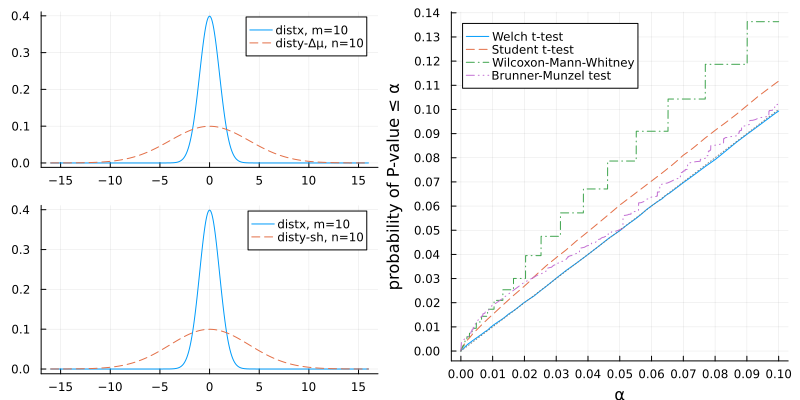

In [2]:
plot_sim(; distx=Normal(0, 1), disty=Normal(0, 4), m=10, n=10)

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal{Float64}(μ=0.0, σ=4.0)
m = 100
n = 100
Δμ = mean(disty) - mean(distx) = 0.0
sh = fair_shift(distx, disty) = 2.7159801469127176e-13


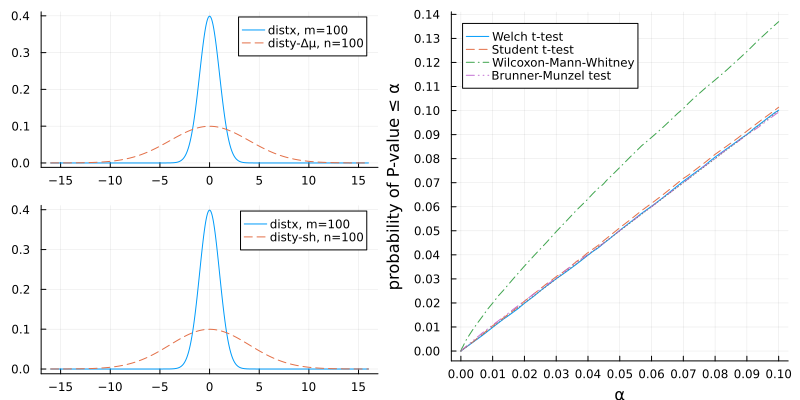

In [3]:
plot_sim(; distx=Normal(0, 1), disty=Normal(0, 4), m=100, n=100)

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal{Float64}(μ=0.0, σ=4.0)
m = 400
n = 100
Δμ = mean(disty) - mean(distx) = 0.0
sh = fair_shift(distx, disty) = 2.7159801469127176e-13


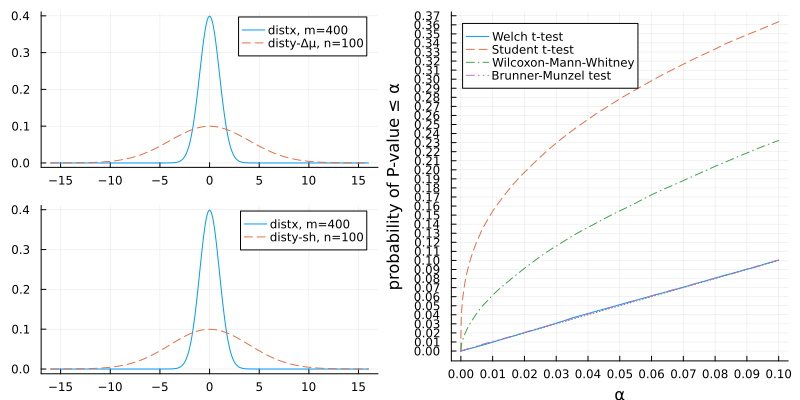

In [4]:
plot_sim(; distx=Normal(0, 1), disty=Normal(0, 4), m=400, n=100)

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal{Float64}(μ=0.0, σ=4.0)
m = 100
n = 400
Δμ = mean(disty) - mean(distx) = 0.0
sh = fair_shift(distx, disty) = 2.7159801469127176e-13


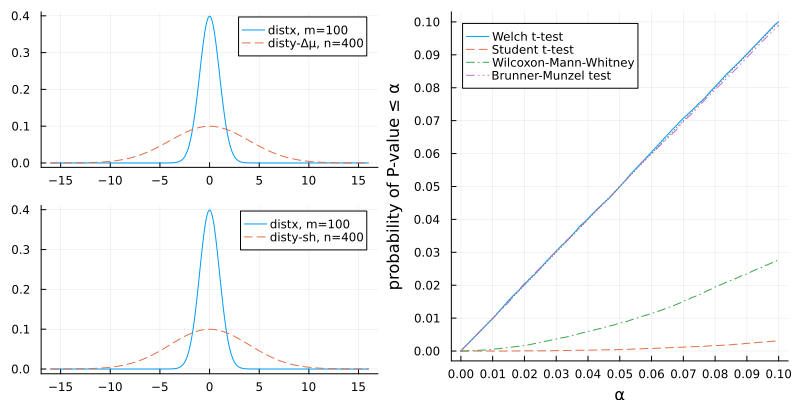

In [5]:
plot_sim(; distx=Normal(0, 1), disty=Normal(0, 4), m=100, n=400)

distx = InverseGamma{Float64}(
invd: Gamma{Float64}(α=3.0, θ=0.125)
θ: 8.0
)

disty = Normal{Float64}(μ=4.0, σ=1.0)
m = 100
n = 100
Δμ = mean(disty) - mean(distx) = 0.0
sh = fair_shift(distx, disty) = 0.8402223063437697


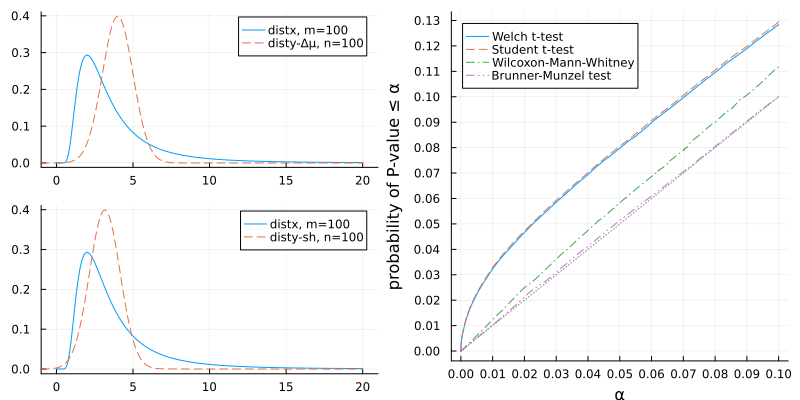

In [7]:
plot_sim(; distx=InverseGamma(3, 8), disty=Normal(4, 1), m=100, n=100, xlim=(-1, 21))

distx = InverseGamma{Float64}(
invd: Gamma{Float64}(α=3.0, θ=0.125)
θ: 8.0
)

disty = Normal{Float64}(μ=4.0, σ=1.0)
m = 100
n = 400
Δμ = mean(disty) - mean(distx) = 0.0
sh = fair_shift(distx, disty) = 0.8402223063437697


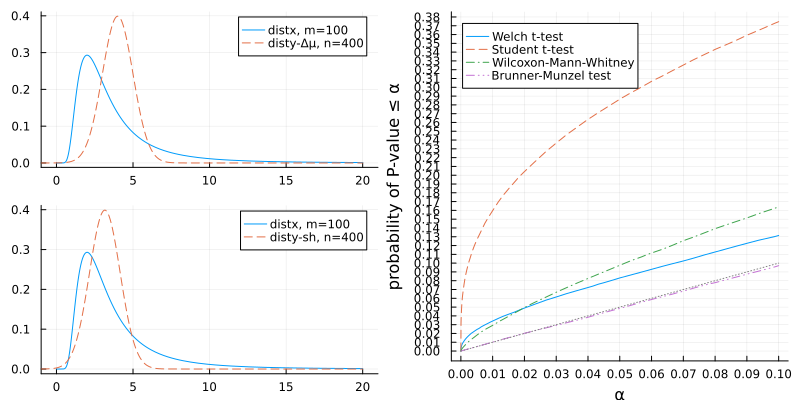

In [8]:
plot_sim(; distx=InverseGamma(3, 8), disty=Normal(4, 1), m=100, n=400, xlim=(-1, 21))

distx = InverseGamma{Float64}(
invd: Gamma{Float64}(α=3.0, θ=0.125)
θ: 8.0
)

disty = Normal{Float64}(μ=4.0, σ=1.0)
m = 400
n = 100
Δμ = mean(disty) - mean(distx) = 0.0
sh = fair_shift(distx, disty) = 0.8402223063437697


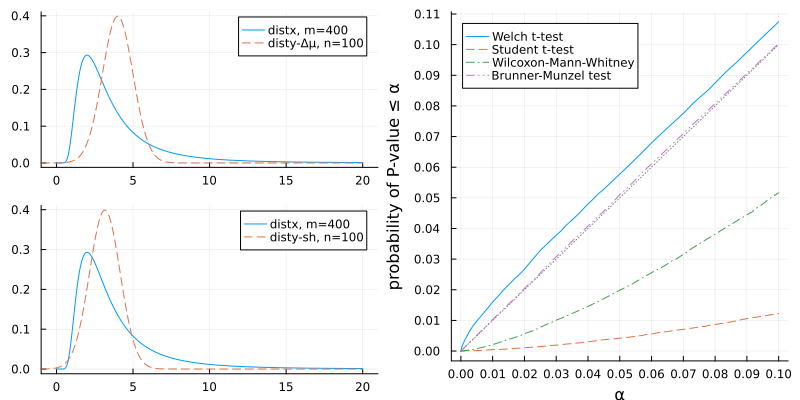

In [9]:
plot_sim(; distx=InverseGamma(3, 8), disty=Normal(4, 1), m=400, n=100, xlim=(-1, 21))